# Part 1


In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import GMM

In [93]:
# Load the dataset
file_path = "C:/Users/muska/Downloads/midterm_partone.csv"
data = pd.read_csv(file_path)

In [94]:
# print first few rows to inspect data columns
print(data.head())
print(data.columns)

   Constant  Stock Change  Inventory Turnover  Operating Profit  \
0         1      0.870332            1.795946          0.115846   
1         1     -0.047347            1.395501          0.436967   
2         1      0.001176            1.664563          0.541016   
3         1     -0.901200            1.605738          0.539399   
4         1     -0.176353            1.591451          0.539938   

   Interaction Effect  Current Ratio  Quick Ratio  Debt Asset Ratio  
0            0.208053       1.672527     0.255171          0.473317  
1            0.609788       1.637261     0.221763          0.489967  
2            0.900555       1.640619     0.189141          0.374269  
3            0.866133       1.436221     0.131944          0.224399  
4            0.859285       1.433140     0.183095          0.213446  
Index(['Constant', 'Stock Change', 'Inventory Turnover', 'Operating Profit',
       'Interaction Effect', 'Current Ratio', 'Quick Ratio',
       'Debt Asset Ratio'],
      dtype

In [ ]:
# Define the dependent variable y and independent variables x
y_val = data['Stock Change'].values   # variable y
x_val = data[['Inventory Turnover', 'Operating Profit']]     # variables x

In [ ]:
# Define instruments (these should be exogenous variables related to x but not to y's error)
iv_val = data[['Current Ratio', 'Quick Ratio', 'Debt Asset Ratio']]

In [ ]:
# Add a constant term to x and instruments z
x_vals = sm.add_constant(x_val).values # Independent variables as numpy array
iv_vals = sm.add_constant(iv_val).values  # Instrument as numpy array

In [ ]:
#Define the GMM Class with Customer Moment Conditions Incorporating Bias.
class gmm(GMM):
    def momcond(self, params):
        # Unpack parameters for the model coefficients and bias term δ
        p0, p1, p2, delta = params  # Only 4 parameters now
        endog = self.endog
        exog = self.exog
        inst = self.instrument

        # Define moment conditions based on the actual number of columns
        error0 = endog - (p0 + p1 * exog[:, 1] + p2 * exog[:, 2])  # Match columns in exog
        error1 = error0 * exog[:, 1]
        error2 = error0 * exog[:, 2]
        error3 = error0 * inst[:, 1] - delta
        error4 = error0 * inst[:, 2] - delta
        error5 = error0 * inst[:, 3] - delta

        # Stack all errors as columns for the GMM moment conditions
        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g

# Initial parameter estimates for GMM (p0, p1, p2, delta)
beta0 = np.array([0.1, 0.1, 0.1, 0.1])

# Prepare and fit the GMM model
gmm_model = gmm(endog=y_val, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=4)
res = gmm_model.fit(beta0)

# Display the summary to analyze the results and check the significance of δ
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.000087
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001698
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.001681
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.001681
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
                                 gmm Results                                  
Dep. Variable:                      y   Hansen J:                        2.852
Model:                            gmm   Prob (Hansen J):                 0.240
Method:                           GMM                                         
Date

# Part 2

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [98]:
# Load the dataset
file_path = "C:/Users/muska/Downloads/midterm_parttwo.csv"
data = pd.read_csv(file_path)

In [100]:
# Encode the target variable (Credit Rating)
data['Credit Rating'] = data['Credit Rating'].apply(lambda x: 1 if x == 'Positive' else 0)

In [101]:
# Encode categorical features using LabelEncoder
label_encoders = {}
for col in ['Requested Credit Amount', 'Number of Dependents', 'Monthly Income', 'Monthly Expense', 'Marital Status']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [79]:
# Separate features and target variable
X = data.drop(columns=['Credit Rating'])
y = data['Credit Rating']

In [80]:
# Split data into training and test sets (50% each)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [81]:
# Fit the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [82]:
# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

In [83]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [84]:
# Display initial results
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[   0  577]
 [   0 3464]]
Precision: 0.8572135609997525
Recall: 1.0
F1 Score: 0.9231179213857429


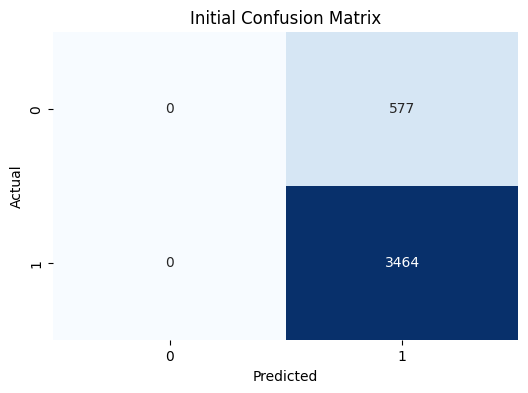

In [85]:
# Plotting the initial confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Initial Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model with Adjusted Threshold for 15% Approval Rate

In [86]:
# Predict probabilities on the test set
y_prob = logistic_model.predict_proba(X_test)[:, 1]

In [87]:
# Calculate the threshold for 15% approval rate
threshold = np.percentile(y_prob, 85)

In [88]:
# Make predictions based on the new threshold
y_pred_thresholded = (y_prob >= threshold).astype(int)

In [89]:
# Recalculate the confusion matrix and metrics with the new threshold
conf_matrix_thresholded = confusion_matrix(y_test, y_pred_thresholded)
precision_thresholded = precision_score(y_test, y_pred_thresholded)
recall_thresholded = recall_score(y_test, y_pred_thresholded)
f1_thresholded = f1_score(y_test, y_pred_thresholded)

In [90]:
# Display updated results
print("\nNew Threshold:", threshold)
print("Updated Confusion Matrix:\n", conf_matrix_thresholded)
print("Updated Precision:", precision_thresholded)
print("Updated Recall:", recall_thresholded)
print("Updated F1 Score:", f1_thresholded)



New Threshold: 0.878591726359296
Updated Confusion Matrix:
 [[ 506   71]
 [2928  536]]
Updated Precision: 0.8830313014827018
Updated Recall: 0.15473441108545036
Updated F1 Score: 0.2633259641365758


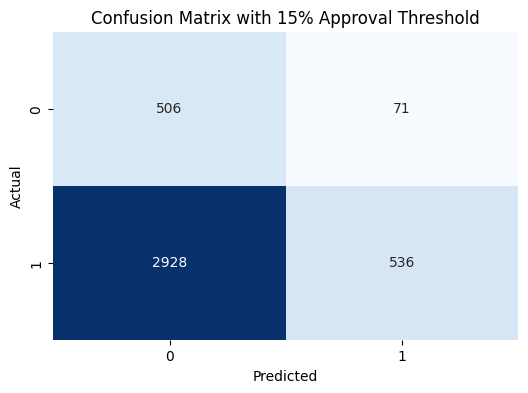

In [91]:
# Plotting the confusion matrix after threshold adjustment
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_thresholded, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix with 15% Approval Threshold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()